# Pitch Similarity Model Testing

This notebook evaluates multiple regression models to predict pitch embedding coordinates (UMAP) from pitch features.

### Features:
- avg_speed
- avg_spin
- avg_break_x
- avg_break_z

### Target:
- umap_1
- umap_2

The goal is to find the best model that minimizes Euclidean distance between predicted and true UMAP coordinates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from time import time

# Load data
df = pd.read_csv("final_dataset_pitchDNA.csv")
X = df[["avg_speed", "avg_spin", "avg_break_x", "avg_break_z"]]
y = df[["umap_1", "umap_2"]]


In [2]:
from sklearn.base import BaseEstimator, RegressorMixin

# Custom wrapper for multi-output regression with Euclidean distance scoring
class EuclideanDistanceWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, base_model):
        self.base_model = base_model

    def fit(self, X, y):
        self.models = []
        for i in range(y.shape[1]):
            model = clone(self.base_model)
            model.fit(X, y.iloc[:, i])
            self.models.append(model)
        return self

    def predict(self, X):
        preds = [model.predict(X) for model in self.models]
        return np.stack(preds, axis=1)

    def score(self, X, y):
        pred = self.predict(X)
        return -np.mean(np.linalg.norm(y - pred, axis=1))  # Negative distance as score


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

models = {
    "KNN": KNeighborsRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR()
}

results = {}

for name, model in models.items():
    wrapped = EuclideanDistanceWrapper(model)
    pipeline = Pipeline([("scaler", StandardScaler()), ("reg", wrapped)])
    start = time()
    scores = cross_val_score(pipeline, X, y, cv=3, scoring="neg_root_mean_squared_error")
    duration = time() - start
    results[name] = {
        "mean_rmse": -scores.mean(),
        "std_rmse": scores.std(),
        "train_time_sec": round(duration, 2)
    }

results_df = pd.DataFrame(results).T
results_df.sort_values("mean_rmse")


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

,mean_rmse,std_rmse,train_time_sec
RandomForest,1.040196,0.083170,45.72
KNN,1.058438,0.089451,1.29
SVR,1.107599,0.091613,91.01
GradientBoosting,1.165839,0.072550,9.55


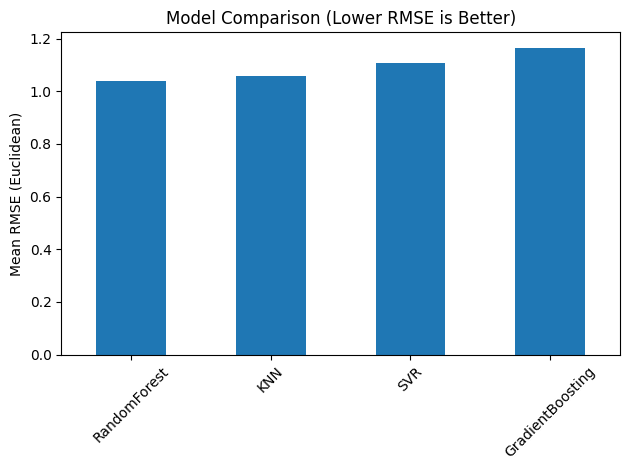

In [4]:
results_df.sort_values("mean_rmse").plot(kind="bar", y="mean_rmse", legend=False, title="Model Comparison (Lower RMSE is Better)")
plt.ylabel("Mean RMSE (Euclidean)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
